# Pipeline #1 - Clustering

<img src="img/pipeline1.png" width="550"/>

This is the very first phase of the project. The idea here is to run an unsupervised [ML algorithm](https://github.com/ucl-pond/pySuStaIn/tree/master) on cross-sectional clinical data of PD patients, to uncover data-driven disease phenotypes (subtypes) with distinct temporal progression patterns.

## Pipeline overview

This pipeline runs the SuStaIn clustering algorithm on non-motor symtoms (NMS) data. 
Specifically, it does the following:

- Data visualization
- Prepares/adjusts the hyperparameters of the algorithm
- Runs the algorithm
- Model stability tracking
- Model performance evaluation

**A disclaimer:** the scientific results found in this notebook (and the other two) are all somewhat (if not very) preliminary and serve the bigger purpose of providing a visual representation of what the final products will look like.

Let's dive in!

First, let's load the libraries that will be used. 

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import wandb
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics


output_folder = "/Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/"
input_folder = "/Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/data/"

Now, let’s load the data. 

The project will utilize three independent datasets containing participants with PD: a training set, a validation set, and a testing set.

1. Canadian Open Parkinson Network (COPN)
2. Parkinson's Progression Marker Initiative (PPMI)
3. UK Biobank

Currently, the two first datasets are available. 

***To load a dataset, input its abbreviation ('copn' or 'ppmi').***\

The pipeline will need to be rerun from here for every dataset to be loaded. 

In [4]:
# User input for dataset
dataset = input("Enter dataset (copn/ppmi): ")
print("Selected dataset:", dataset)

# Dictionary to map dataset names to file paths
data_paths = {
    "copn": input_folder + "dataset_1_copn/data.xlsx",
    "ppmi": input_folder + "dataset_2_ppmi/data.xlsx"
}

# Get the data path based on the dataset
data_path = data_paths.get(dataset, "")
if not data_path:
    raise ValueError("Invalid dataset name provided")

# Dataset demographics
demographics = pd.read_excel(data_path, sheet_name="demographics")

# Algorithm inputs 

# prob_nl input
prob_nl = pd.read_excel(data_path, sheet_name="1_prob_nl").values
print("prob_nl:")
print("shape:", prob_nl.shape)
print(prob_nl)

# prob_score input
tmp = pd.read_excel(data_path, sheet_name="2_prob_score").values
original_shape = tmp.shape
print(original_shape)

desired_shape = (prob_nl.shape[0], 26, 4)
prob_score = tmp.reshape(desired_shape)
print("prob_score:")
print("shape:", prob_score.shape)
print(prob_score)

# score_vals input
score_vals = pd.read_excel(data_path, sheet_name="3_score_vals").values
print("score_vals")
print("shape:", score_vals.shape)
print(score_vals)


Selected dataset: copn
prob_nl:
shape: (956, 26)
[[0.752 0.851 0.741 ... 0.885 0.93  0.874]
 [0.752 0.851 0.065 ... 0.029 0.017 0.874]
 [0.062 0.037 0.065 ... 0.029 0.017 0.031]
 ...
 [0.062 0.851 0.065 ... 0.029 0.017 0.031]
 [0.752 0.851 0.065 ... 0.029 0.93  0.874]
 [0.752 0.851 0.741 ... 0.029 0.017 0.031]]
(24856, 4)
prob_score:
shape: (956, 26, 4)
[[[0.06198765 0.06198765 0.06198765 0.06198765]
  [0.0371787  0.0371787  0.0371787  0.0371787 ]
  [0.0648523  0.0648523  0.0648523  0.0648523 ]
  ...
  [0.02875    0.02875    0.02875    0.02875   ]
  [0.0174964  0.0174964  0.0174964  0.0174964 ]
  [0.0314284  0.0314284  0.0314284  0.0314284 ]]

 [[0.06198765 0.06198765 0.06198765 0.06198765]
  [0.0371787  0.0371787  0.0371787  0.0371787 ]
  [0.7405908  0.0648523  0.0648523  0.0648523 ]
  ...
  [0.885      0.02875    0.02875    0.02875   ]
  [0.0174964  0.9300144  0.0174964  0.0174964 ]
  [0.0314284  0.0314284  0.0314284  0.0314284 ]]

 [[0.06198765 0.06198765 0.7520494  0.06198765]
  [0

## Data visualization

Let's look at the summary statistics and distribution of some basic demographic variables. 


count    387.000000
mean      67.369509
std        9.108181
min       36.000000
25%       62.000000
50%       68.000000
75%       74.000000
max       90.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'Age in COPN')

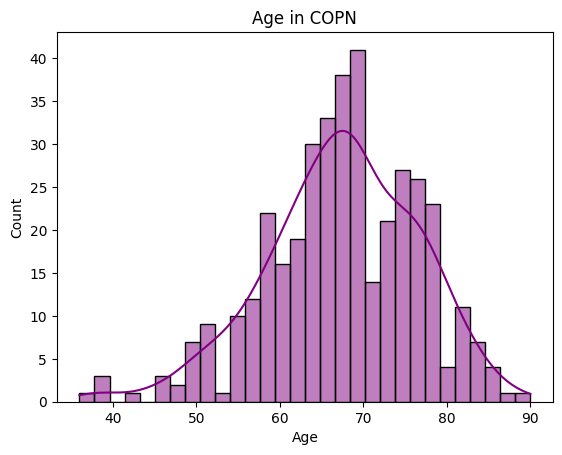

In [55]:
# Age
print(demographics['Age'].describe())
sns.histplot(demographics['Age'],
            bins=30,           # increase "resolution"
            color='purple',    # change color
            kde=True       
).set_title("Age in " + dataset.upper())

count    384.000000
mean      61.403646
std        9.677358
min       34.000000
25%       55.000000
50%       62.000000
75%       68.000000
max       88.000000
Name: Onset, dtype: float64


Text(0.5, 0, 'Age at onset')

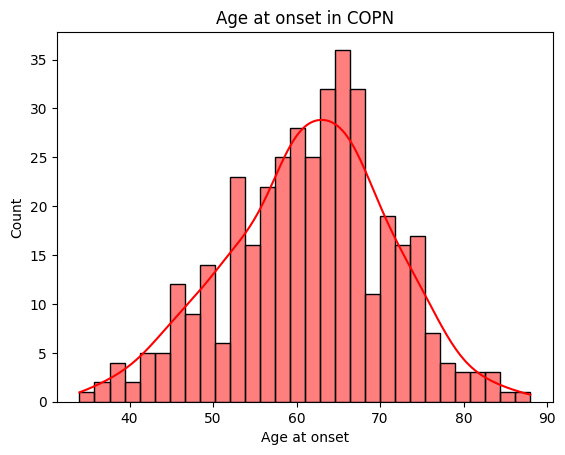

In [48]:
# Age at onset
print(demographics['Onset'].describe())
fig = sns.histplot(demographics['Onset'],
            bins=30,         
            color='red',   
            kde=True        
).set_title("Age at onset in " + dataset.upper())

plt.xlabel('Age at onset')

count    385.000000
mean       7.910130
std        5.698714
min        0.500000
25%        3.500000
50%        6.300000
75%       10.900000
max       30.200000
Name: Duration, dtype: float64


Text(0.5, 0, 'Disease duration (years)')

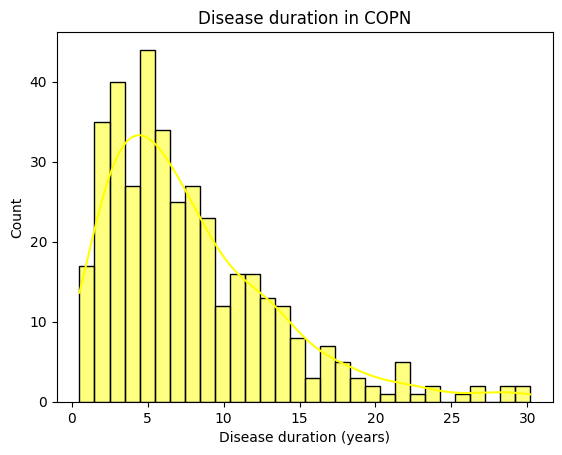

In [50]:
# Disease duration
print(demographics['Duration'].describe())
sns.histplot(demographics['Duration'],
            bins=30,          
            color='yellow',   
            kde=True        
).set_title("Disease duration in " + dataset.upper())

plt.xlabel('Disease duration (years)')

count    386.000000
mean      10.849741
std        3.308896
min        1.000000
25%        9.000000
50%       11.000000
75%       13.000000
max       17.000000
Name: Education, dtype: float64


Text(0.5, 0, 'Education (years)')

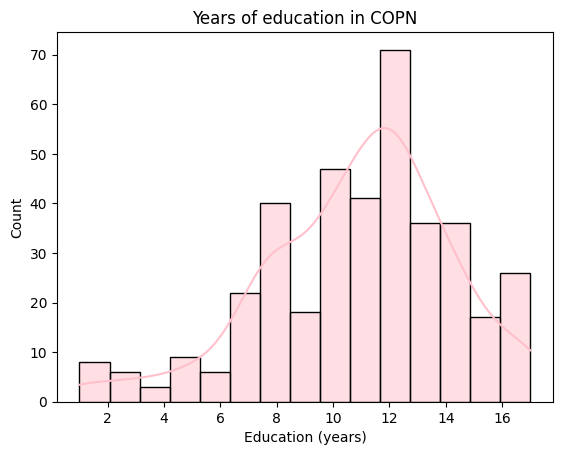

In [53]:
# Years of education
print(demographics['Education'].describe())
sns.histplot(demographics['Education'],
            color='pink',   
            kde=True        
).set_title("Years of education in " + dataset.upper())

plt.xlabel('Education (years)')

count    401.000000
mean       1.324190
std        0.468656
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Gender, dtype: float64


Text(0.5, 1.0, 'Gender in COPN')

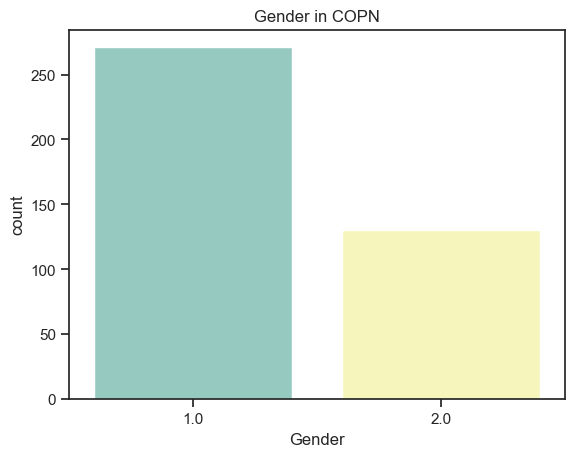

In [79]:
# Gender
print(demographics['Gender'].describe())
sns.countplot(x ='Gender', 
              data = demographics, 
              palette="Set3"
              ).set_title("Gender in " + dataset.upper())

count    349.000000
mean      25.031519
std        3.566548
min        6.000000
25%       23.000000
50%       25.000000
75%       28.000000
max       30.000000
Name: MoCA, dtype: float64


Text(0.5, 0, 'MoCA')

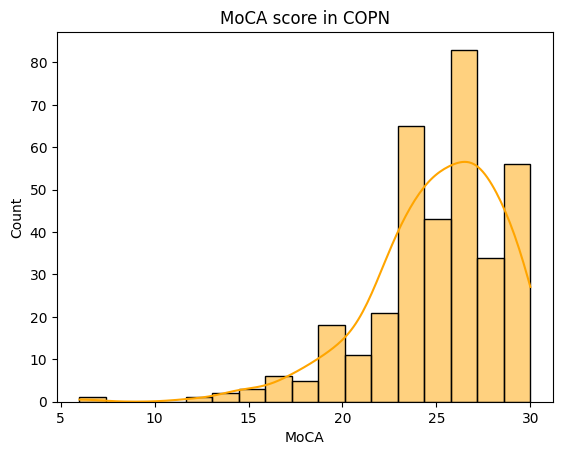

In [5]:
# Distribution of the MoCA score (cognition)

print(demographics['MoCA'].describe())
sns.histplot(demographics['MoCA'],
            color='orange',   
            kde=True        
).set_title("MoCA score in " + dataset.upper())

plt.xlabel('MoCA')

The distribution of the MoCA in the COPN dataset is very negatively skewed! This will have to be considered when performing statistical analyses on the variable.

How does the age vary among stages of the disease?

Text(0.5, 0, 'H&Y stage')

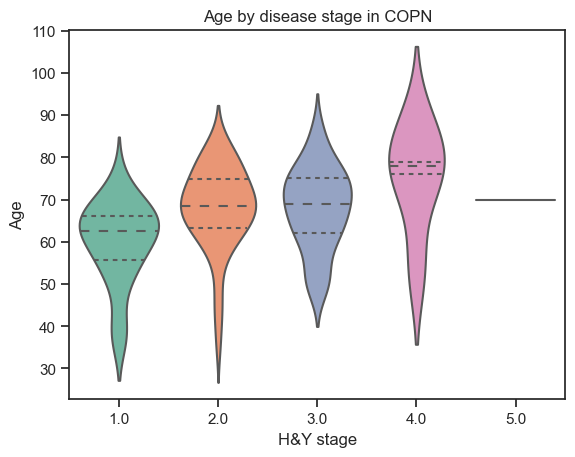

In [99]:
# Age by H&Y stages
sns.violinplot(data=demographics, 
               x="Hoehn", 
               y="Age", 
               split=True, 
               inner="quart", 
               palette="Set2"
               ).set_title("Age by disease stage in " + dataset.upper())
plt.xlabel('H&Y stage')

How does disease stage differ among genders?

/Users/song/Library/Python/3.9/lib/python/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'H&Y stage')

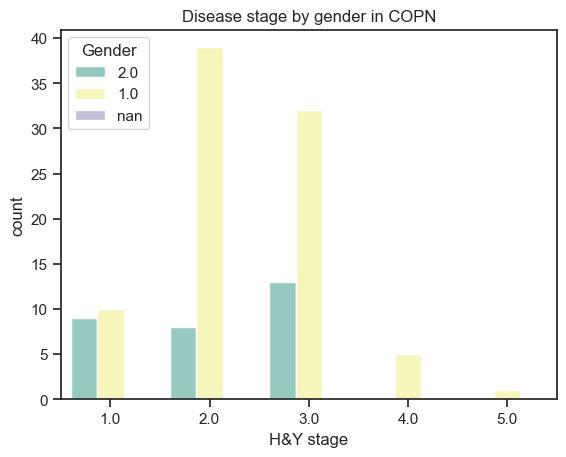

In [105]:
# Stages by gender
demographics['Gender'] = demographics['Gender'].astype(str)

sns.countplot(data=demographics, 
              x='Hoehn', 
              hue='Gender',
              palette="Set3"
              ).set_title("Disease stage by gender in " + dataset.upper())
plt.xlabel('H&Y stage')

## Inputting/adjusting hyperparameters

Since the input data is ordinal, the SuStaIn version being used is **Ordinal SuStaIn**. 

Values to be input by user (hyperparameters of the model):

- *n_s_max*: models with 1 to *n_s_max* clusters will be fit by the algorithm
- *n_iterations*: number of MCMC iterations 

Those values need to be adjusted in the process of hyperparameter tuning. For now, this needs to be done manually. Tools (*i.e.* Optuna, WandB sweeps) are currently explored to automate this process. 

***To set the hyperparameters, input the values directly.***

In [116]:
# n_s_max
n_s_max = input("Enter a value for n_s_max: ")
print("Max number of clusters is set to:", n_s_max)

Max number of clusters is set to: 4


In [117]:
# n_iterations
n_iterations = input("Enter a value for n_iterations: ")
print("Number of MCMC iterations is set to:", n_iterations)

Number of MCMC iterations is set to: 100000


## Running the algorithm

Here, the SuStaIn algorithm is called with the inputs prepared previously. The runs are tracked on wandb. The following code needs to be executed on every run. 

- For the **training** phase: the output folder (var '*output_path*') has to be empty, which will trigger the algorithm to run on the data provided as input (training set). 
- Fort the **validation** phase: the output folder has to point to the previously trained model folder. The trained model will be fit to the validation set. 
- For the **testing** phase: the output folder has to point to the previously trained model folder. The trained model will be fit to the test set.  

In [108]:
output_no = random.randint(100, 999)

output_path = output_folder + str(output_no)
seed = 5

biomarkers = ['Cognition', 'Psychosis', 'Depression', 'Anxiety', 'Apathy',
            'Impulsivity', 'Insomnia', 'Sleepiness', 'Pain', 'Incontinence',
            'Constipation', 'Dizziness', 'Fatigue', 'Speech', 'Drooling',
            'Swallowing', 'Eating', 'Dressing', 'Hygiene', 'Handwriting', 'Hobbies',
            'Rolling', 'Tremor', 'Arising', 'Walking', 'Freezing']

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Brainhack pySuStaIn",

    # track hyperparameters and run metadata
    config={
    "dataset": dataset,
    "output_no": output_no,
    "n_s_max": n_s_max,
    "n_iterations": n_iterations,
    "seed": seed
    }
)

# create folder for results if it doesn't exist already
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# The initializer for the scored events model implementation of AbstractSustain
#         Parameters:
#           prob_nl                     - probability of negative/normal class for all subjects across all biomarkers 
#                                         dim: number of subjects x number of biomarkers
        
#           prob_score                  - probability of each score for all subjects across all biomarkers
#                                         dim: number of subjects x number of biomarkers x number of scores
#           score_vals                  - a matrix specifying the scores for each biomarker
#                                         dim: number of biomarkers x number of scores
#           biomarker_labels            - the names of the biomarkers as a list of strings
#           N_startpoints               - number of startpoints to use in maximum likelihood step of SuStaIn, typically 25
#           N_S_max                     - maximum number of subtypes, should be 1 or more
#           N_iterations_MCMC           - number of MCMC iterations, typically 1e5 or 1e6 but can be lower for debugging
#           output_folder               - where to save pickle files, etc.
#           dataset_name                - for naming pickle files
#           use_parallel_startpoints    - boolean for whether or not to parallelize the maximum likelihood loop
#           seed                        - random number seed

sustain_input_zscore = pySuStaIn.OrdinalSustain(
                            prob_nl,     
                            prob_score,      
                            score_vals,
                            biomarkers,
                            25,
                            int(n_s_max),
                            int(n_iterations), 
                            output_path, 
                            dataset, 
                            True,
                            seed)                      
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input_zscore.run_sustain_algorithm()

wandb.finish()

Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/532/pickle_files/copn_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/532/pickle_files/copn_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/532/pickle_files/copn_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: /Users/song/Documents/dev/repos/10. brainhack 2024/bhSubtypingPD/brainhack_source/results/532/pickle_files/copn_subtype3.pickle. Using pickled variables for 3 subtype.


Let's view the results. 

['.DS_Store', '4subtypes.png', '3subtypes.png']


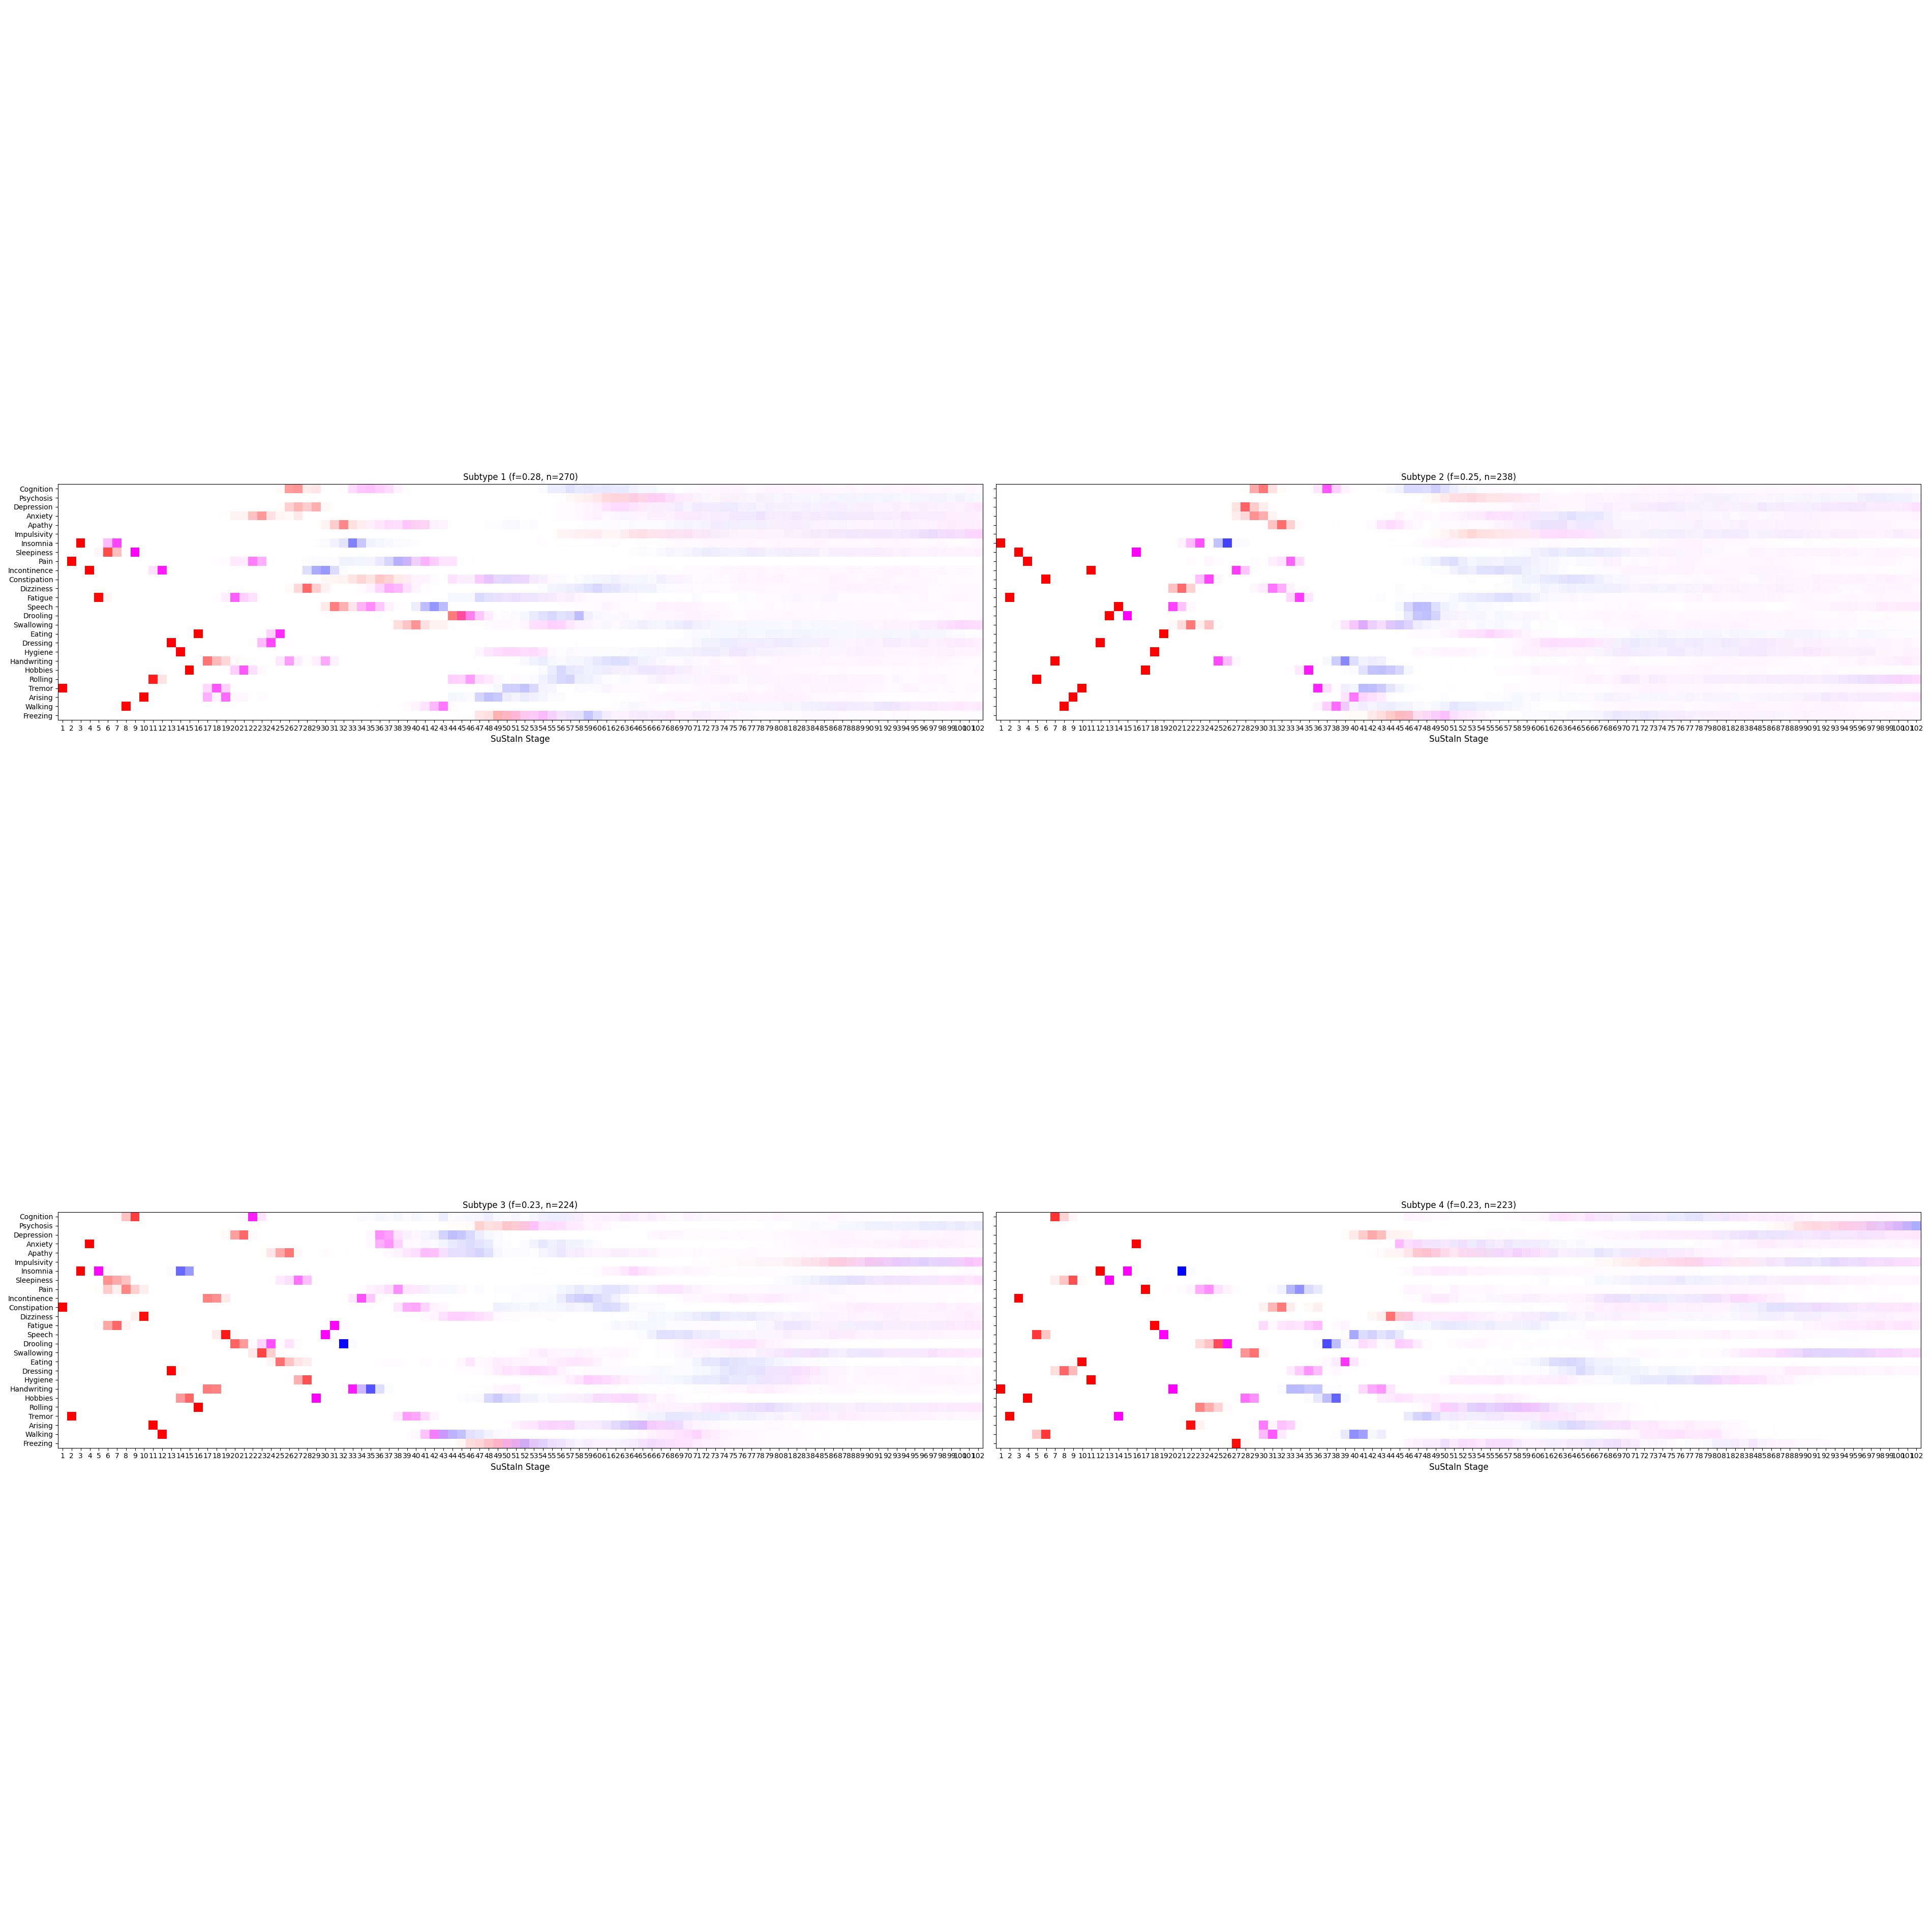

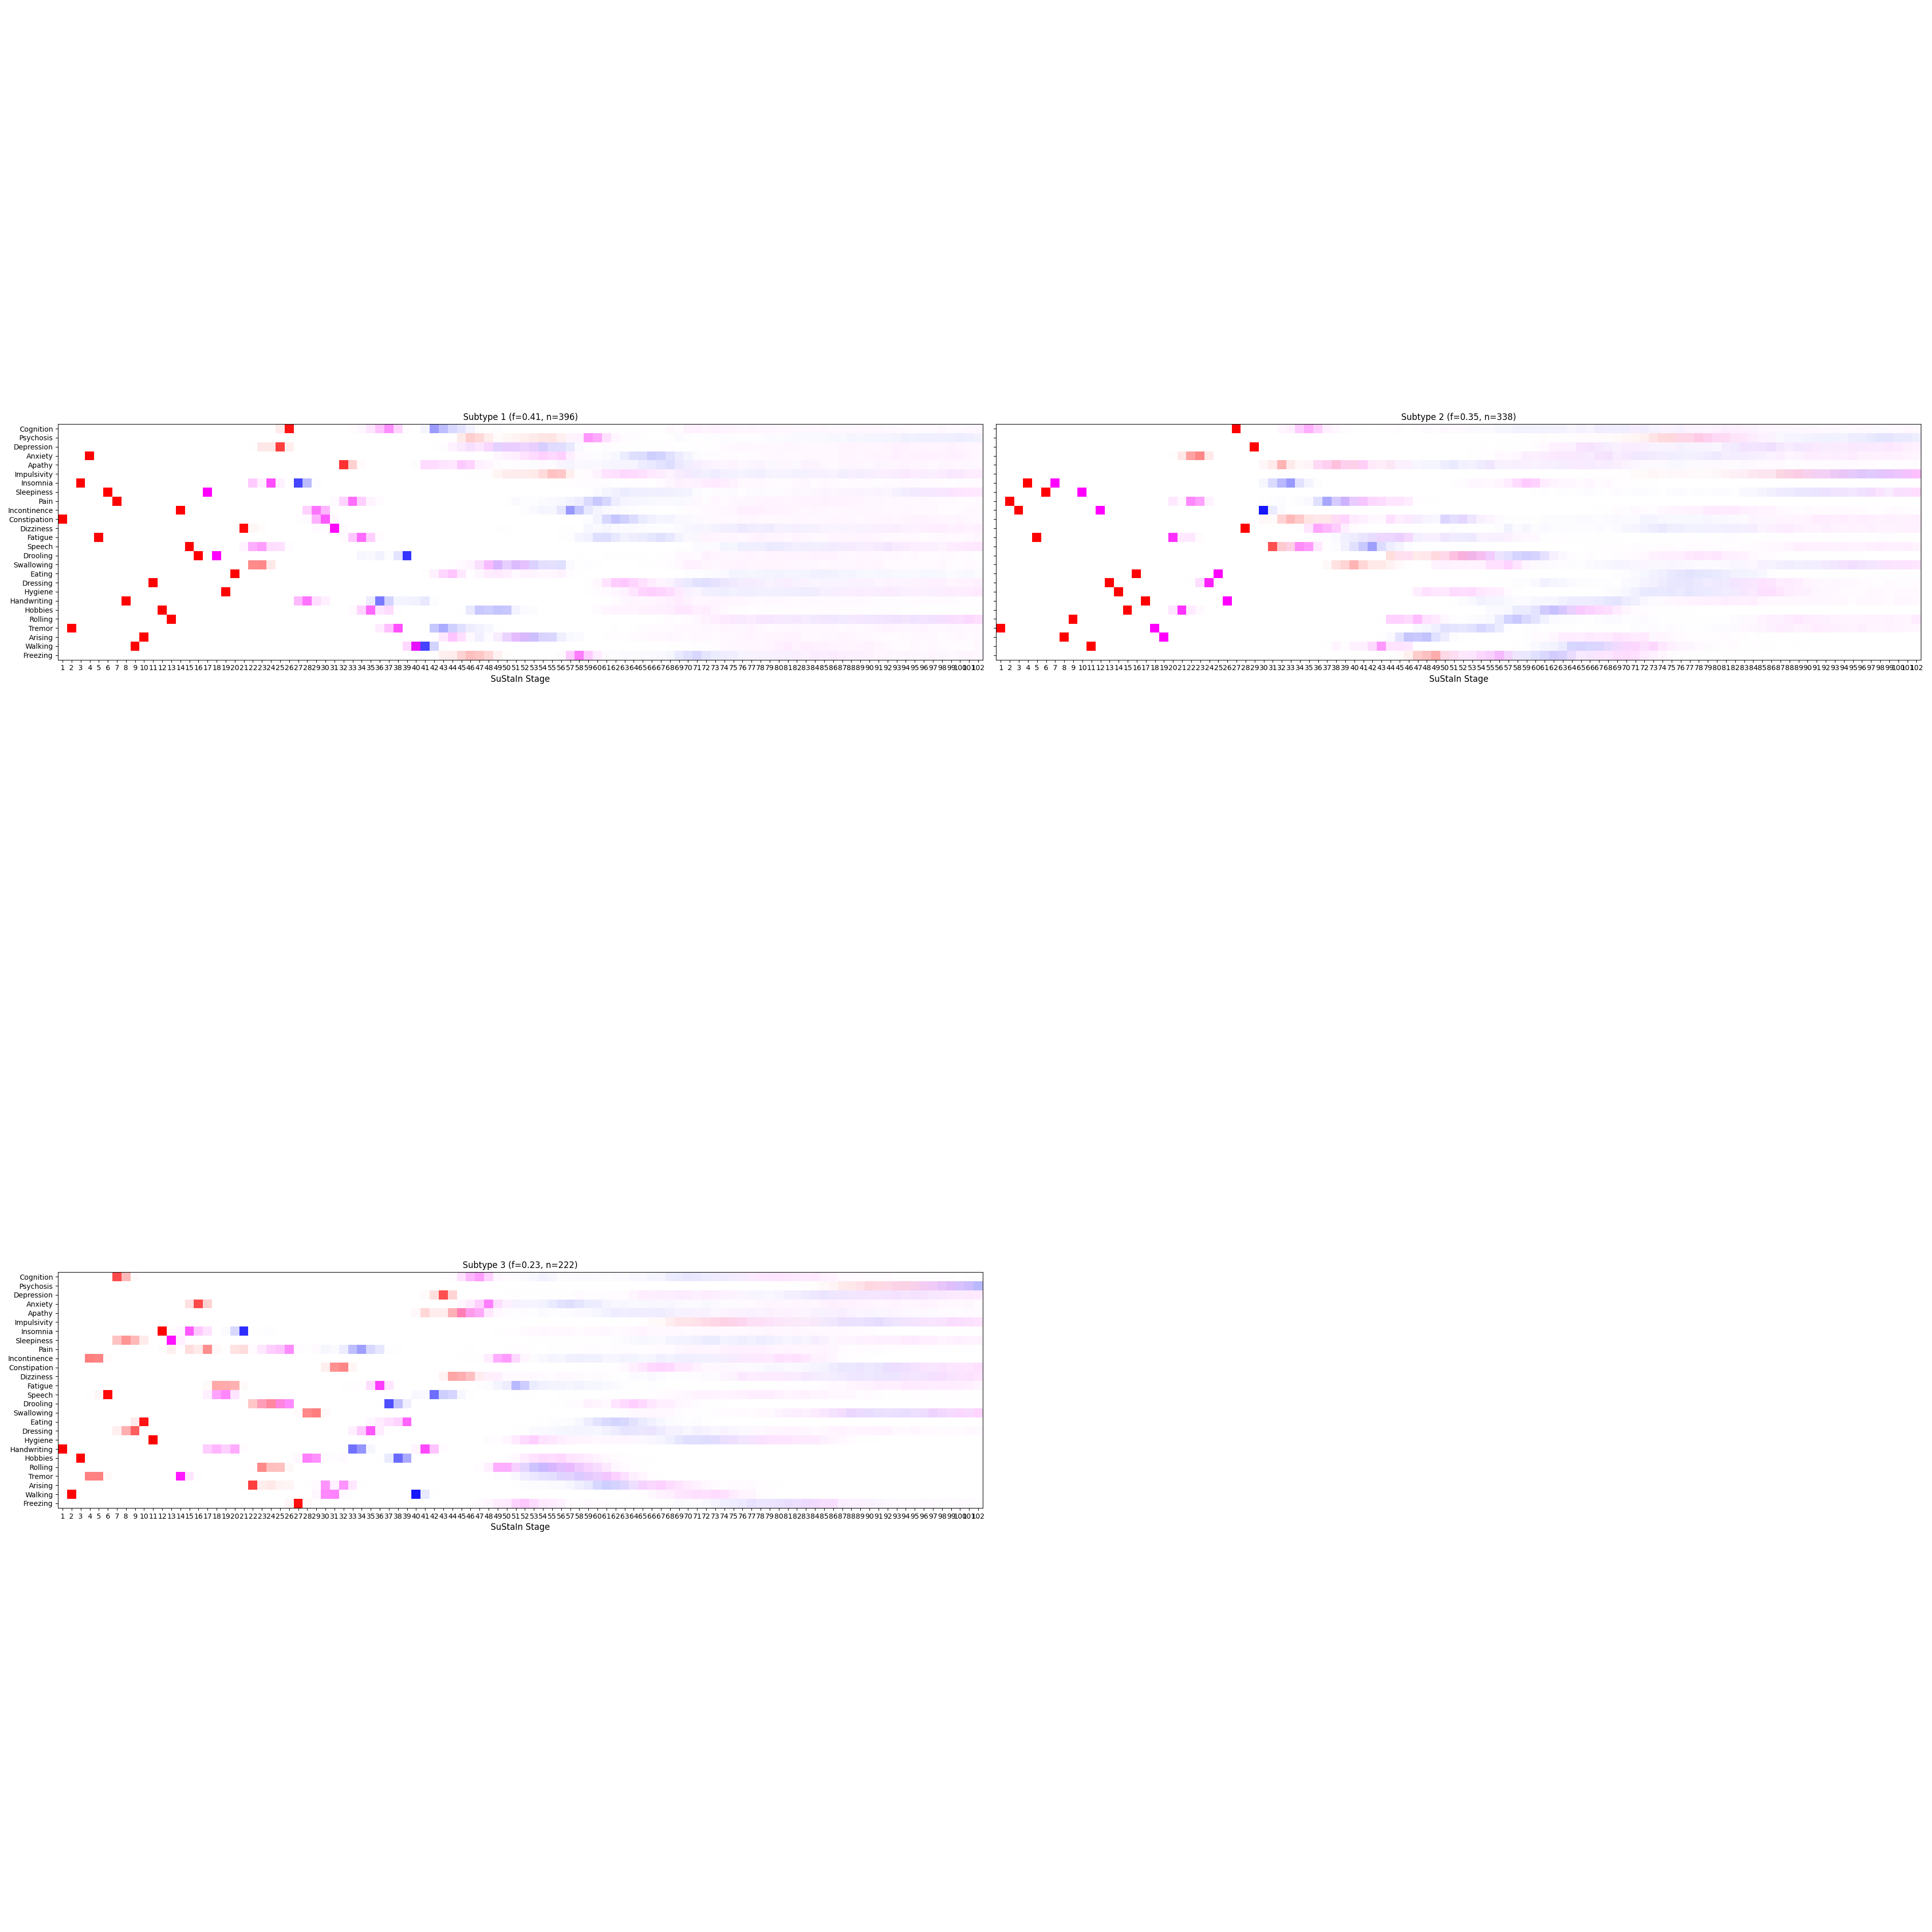

In [115]:
from IPython.display import Image, display

imageList = os.listdir(output_path + '/plots')
print(imageList)

for image in imageList:
    if image.endswith('.png'):
        display(Image(filename=output_path + '/plots/' + image))

Let's write the results to a file. 

In [ ]:
n_subtypes = 3
pickle_filename_s = output_folder + '/pickle_files/' + dataset + '_subtype' + str(n_subtypes) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    print(variable)
    
    # Add SuStaIn output to dataframe
    results = pd.DataFrame()
    results.loc[:,variable] = pk[variable] 

# Write results to excel file
writer = pd.ExcelWriter(output_folder + '/' + output_no + '.xlsx', engine='openpyxl', mode='a', if_sheet_exists = 'replace')
results.to_excel(writer, sheet_name = n_subtypes)
writer.close()

## Model stability tracking

In order to find the optimal hyperparameter values for our trained model, we need to evaluate the stability of the obtained models throughout the hyperparameter tuning process. This can be done by using the **Adjusted Rand Index (ARI)**. 

### Adjusted Rand Index (ARI)

The ARI is a measure of the similarity between two data clusterings. The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The raw RI score is then “adjusted for chance” into the ARI score.

The ARI ranges from − 1 to + 1:
 
- ARI = 1: Perfect agreement between clusterings
- ARI = 0: The expected similarity between two random clusterings (given the same number of clusters and points)
- ARI = -1: Perfect disagreement between clusterings

***To compare two models, input the 'output_no' of the two models.***

In [119]:
def get_excel_path(no_model):
    return output_folder + str(no_model) + "/" + str(no_model) + ".xlsx"

def get_input_model(no_model):
    return pd.read_excel(get_excel_path(no_model), sheet_name="stability")["Stab"].tolist()

no_model_1 = input()
no_model_2 = input()

print("First model: #", no_model_1)
print("Second model: #", no_model_2)

print('ARI: ', adjusted_rand_score(get_input_model(no_model_1), get_input_model(no_model_2)))

First model: # 841
Second model: # 532
ARI:  0.1443848207063997


Here, an ARI of 0.14 indicates that the clustering results from the two models show some level of similarity beyond what would be expected by chance, but it is not very high. Hyperparameters therefore need to be adjusted in consequence. 

## Model performance evaluation

Clustering requires evaluating the quality and meaningfulness of the clusters created by the model. With no known ground truth labels, evaluation must be performed using the model itself, through internal evaluation metrics, such as the [silhouette coefficient](https://www.sciencedirect.com/science/article/abs/pii/B9780128219294000020). 

### Silhouette coefficient
The silhouette score is a metric that measures how well each data point fits into its assigned cluster, by measuring how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Values range from -1 to 1, where a higher value indicates better-defined clusters.

***Input the output_no of a model to compute its silhouette coefficient.***

In [16]:
# User input for output_no
output_no = input("Enter output_no: ")
print("Selected model: #", output_no)

# TODO This needs to be dynamic
tmp = pd.read_excel('/Users/song/Documents/dev/repos/10. brainhack 2024/SubtypingPD/brainhack_source/results/841/841.xlsx', sheet_name="3st")
X = tmp.iloc[:, 7: 33].values
labels = tmp['ml_subtype'].values

# Computing the silhouette coefficient
print('Silhouette coefficient: ', metrics.silhouette_score(X, labels, metric='euclidean'))


Selected model: # 841
Silhouette coefficient:  0.003243252594606985


A silhouette coefficient close to 0 indicates poorly defined clusters. In a case like this one, depending where we are in our ML pipeline, we should consider retuning the model. 

Furthermore, the authors of the algorithm provide the following code for plotting the models' likelihood. These plots help in choosing the appropriate model (most appropriate number of subtypes to fit the data).

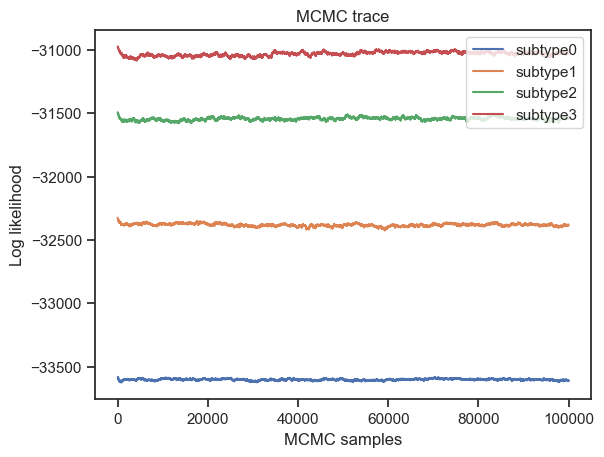

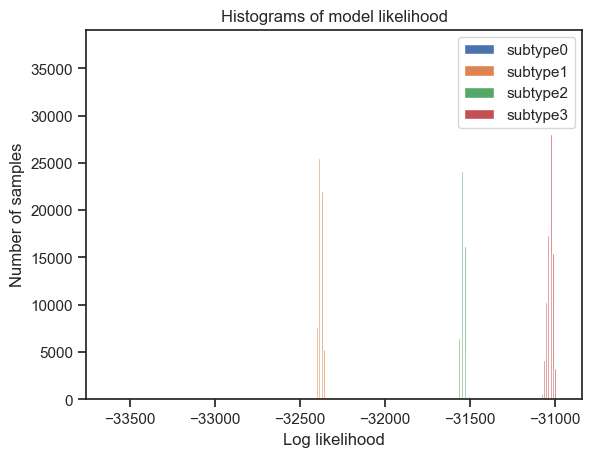

In [125]:
from pathlib import Path
import pickle

# go through each subtypes model and plot MCMC samples of the likelihood
for s in range(4):
    pickle_filename_s           = output_folder + str(output_no) + '/pickle_files/' + dataset + '_subtype' + str(s) + '.pickle'
    pickle_filepath             = Path(pickle_filename_s)
    pickle_file                 = open(pickle_filename_s, 'rb')
    loaded_variables            = pickle.load(pickle_file)
    samples_likelihood          = loaded_variables["samples_likelihood"]
    pickle_file.close()

    _ = plt.figure(0)
    _ = plt.plot(range(100000), samples_likelihood, label="subtype" + str(s))
    _ = plt.figure(1)
    _ = plt.hist(samples_likelihood, label="subtype" + str(s))
    
_ = plt.figure(0)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('MCMC samples')
_ = plt.ylabel('Log likelihood')
_ = plt.title('MCMC trace')
    
_ = plt.figure(1)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Log likelihood')  
_ = plt.ylabel('Number of samples')  
_ = plt.title('Histograms of model likelihood')

I will analyse these plots along with the stability and performance metrics, in order to choose the most fitting model.

## What is next?

In conclusion, Pipeline #1 implements SuStaIn on non-motor symptoms (NMS) datasets. The next steps for this pipeline will be to automate hyperparameter tuning, as well as implementing cross-validation, which is provided with the algorithm.